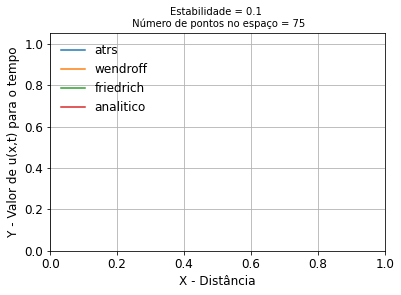

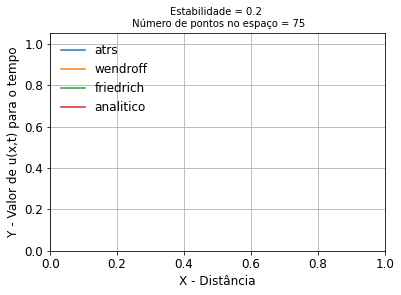

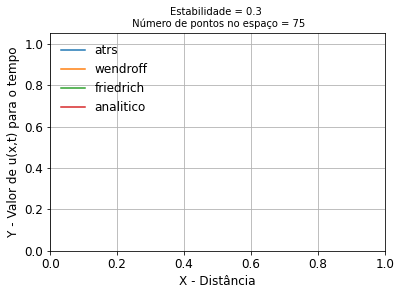

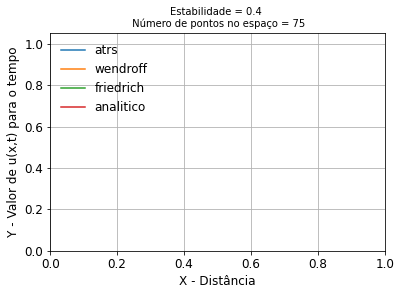

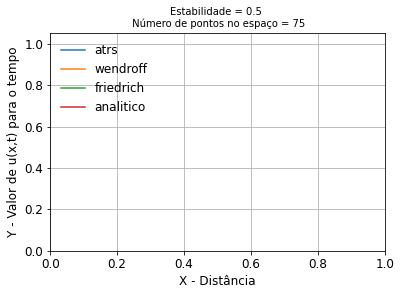

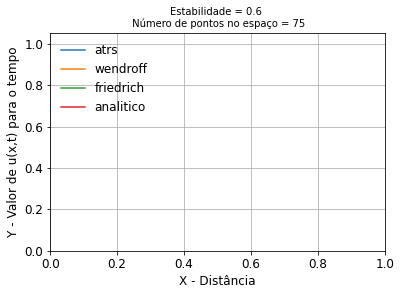

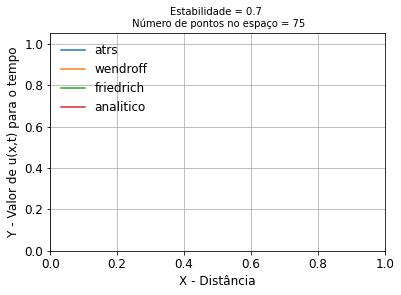

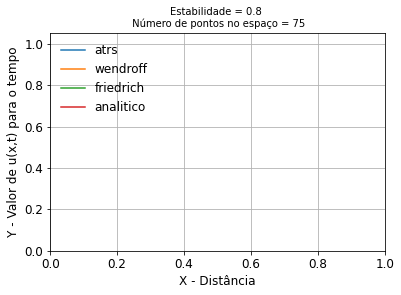

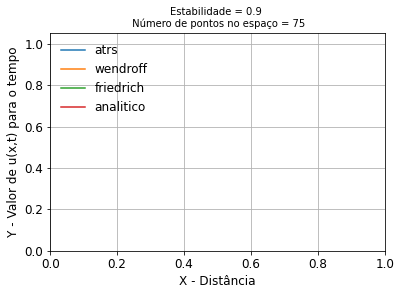

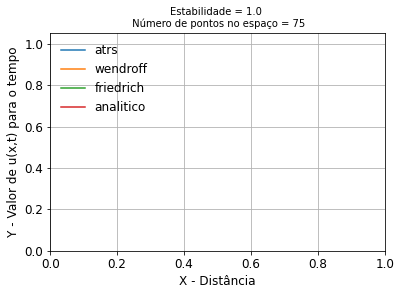

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from scipy import interpolate
from numpy import where
from math import sin
import time

# Definindo a função
def f(x):
    f = np.zeros_like(x)
    """Atribuindo um valor de 0,0 para valores menores que 0,2 e maiores que 0,4"""
    f[np.where(x < 0.2)] = 0.0
    f[np.where(x > 0.4)] = 0.0
    """Atribuindo um valor de 1,0 para valores 0,2<x<0,4"""
    x_esquerda = 0.2
    x_direita = 0.4
    f = where((x_esquerda < x) & (x < x_direita), 1, f)
    return f


def atrs(u):
    # Avançar no tempo e retroceder no espaço.
    u[1:-1] = c*u[:-2] + (1-c)*u[1:-1]
    return u[1:-1]


def wendroff(u):
    # Método de Lax-Wendroff
    u[1:-1] = (1 - c**2)*u[1:-1] + c/2.0*(1 + c)*u[:-2] - c/2.0*(1 - c)*u[2:]
    return u[1:-1]


def friedrich(u):
    # Método advectivo de Lax-Friedrich
    u[1:-1] = (u[:-2] + u[2:])/2.0 - c*(- u[:-2] + u[2:])/2.0
    return u[1:-1]


# Função de inicialização para a animação
def inicio():
    for linha in linhas:
        linha.set_data([], [])
    return linhas
# Função de animação


def animado(i):
    for k, linha in enumerate(linhas):
        if (k == len(linhas)-1):
            linha.set_data(x, u_analitica[i, :])
        else:
            linha.set_data(x, u_solucoes[k, i, :])
    return linhas

passo_do_grafico = 1.0/10.0
while passo_do_grafico <= 1.0:
  # Usado para a construção de tabela.
  a = 1.0
  # Velocidade da onda
  t_min = 0.0
  t_max = 1.0
  # Hora de início e parada
  x_min = 0.0
  x_max = 1.0
  # Início e fim no domínio espacial
  N_pontos_x = 75
  """Quanto mais pontos, mais pesada e mais precisa fica a solução"""
  # Número de pontos no espaço
  c = round(passo_do_grafico,2)
  # Professor pediu para comparar a estabilidade com a acurácia.
  # Precisa de c <= 1 para estabilidade
  # A discretização
  dx = float((x_max - x_min) / N_pontos_x)
  # Tamanho do passo no espaço
  dt = (c / a)*dx
  # Passo de tempo estável, calculado a partir dos requisitos de estabilidade
  x = np.linspace(x_min, x_max, N_pontos_x + 1)
  # Discretização do espaço
  N_pontos_t = int((t_max - t_min) / dt)
  # Número de etapas de tempo
  tempo = np.linspace(t_min, t_max, N_pontos_t)
  # Discretização do tempo
  metodos = [atrs, wendroff, friedrich]
  # Métodos escolhidos
  u_solucoes = np.zeros((len(metodos), len(tempo), len(x)))
  # Soluções para os métodos
  u_analitica = np.zeros((len(tempo), len(x)))

  # A solução analítica
  for k, metodo in enumerate(metodos):
      # Resolve para todos os solucionadores na lista
      u = f(x)
      u_n = np.zeros((len(tempo), len(x)))  # contém a solução numérica
      
      for i, t in enumerate(tempo[1:]):
          if k == 0:
              u_analitica[i, :] = f(x-a*t)
              # A solução analítica para este tempo
          u_bc = interpolate.interp1d(x[-2:], u[-2:])
          # Interpolar a direita.
          u[1:-1] = metodo(u[:])
          # Calcular solução numérica do interior
          u[-1] = u_bc(x[-1] - a*dt)
          # Interpolar entre uma característica para encontrar o valor limite
          u_n[i, :] = u[:]
          # Armazenando a solução
      u_solucoes[k, :, :] = u_n

  # Gráfico interativo
  # Primeiro configure a figura, o eixo e o elemento do gráfico que queremos animar
  figura = plt.figure(figsize=(6, 4))
  plt.rcParams.update({'font.size': 12})
  plt.rcParams.update({'lines.linewidth': 1.5})
  eixos = plt.axes(xlim=(x_min, x_max), ylim=(np.min(u_n), np.max(u_n)*1.05))
  linhas = []
  legendas = []

  for metodo in metodos:
      linha, = eixos.plot([], [])
      legendas.append(metodo.__name__)
      linhas.append(linha)
  linha, = eixos.plot([], [])
  # Linha de plot para a solução analítica
  linhas.append(linha)
  legendas.append('analitico')
  plt.title(f'Estabilidade = {c} \n Número de pontos no espaço = {N_pontos_x}', fontdict = {'fontsize': 10})
  plt.xlabel('X - Distância')
  plt.ylabel('Y - Valor de u(x,t) para o tempo')
  plt.legend(legendas, loc=2, frameon=False)
  plt.grid(True)

  animacao = animation.FuncAnimation(
      figura, animado, init_func=inicio, frames=N_pontos_t, interval=100, blit=False)
  animacao.save(f'CODIGO4_C{c}_Nx{N_pontos_x}.gif', writer = "pillow", fps=10 )
  plt.show()
  passo_do_grafico += (1.0/10.0)
  time.sleep(5)
